In [29]:
from transformers.utils import send_example_telemetry
from transformers import  ViTImageProcessor, ViTForImageClassification
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import evaluate
import numpy as np
from transformers import create_optimizer, TFAutoModelForImageClassification
from datasets import load_dataset, load_metric, dataset_dict
import matplotlib.pyplot as plt
from keras import callbacks

In [30]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [143]:
dataset = load_dataset("imagefolder", data_dir=r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane")

Resolving data files:   0%|          | 0/8000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Jan/.cache/huggingface/datasets/imagefolder/default-cff075024fd9a4ff/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [144]:
metric = load_metric("accuracy")

In [145]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
})

In [146]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[0]

'dyed-lifted-polyps'

In [147]:
processor = ViTImageProcessor.from_pretrained(model_checkpoint)
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [148]:
# 90% train, 10% test + validation
train_test = dataset["train"].train_test_split(test_size=0.2, shuffle = True, seed = 200,)
# Split the 10% test + valid in half test, half valid
test_valid = train_test['test'].train_test_split(test_size=0.5, shuffle = True, seed = 200 )
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = dataset_dict.DatasetDict({
    'train': train_test['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [149]:
 splitted_dataset = train_test_valid_dataset

In [150]:
# def split_dataset(test_size, dataset):
#     splits = dataset["train"].train_test_split(test_size)
#     return splits

In [151]:
# splitted_dataset = split_dataset(0.15, dataset)

In [152]:
# splitted_dataset

In [153]:
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
})

In [154]:
splitted_dataset['train'][1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x576>,
 'label': 7}

In [155]:
size = (processor.size["height"], processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
#         layers.RandomContrast(0.8, 1.2),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="train_data_augmentation",
)

In [156]:
def preprocess_train(example_batch, processor, train_data_augmentation):
    inputs = processor([x for x in example_batch['image']], return_tensors='tf')

    # Używanie list comprehension do augmentacji i transpozycji obrazów
    inputs["pixel_values"] = tf.stack([
        tf.transpose(
            train_data_augmentation(
                tf.transpose(image, [1, 2, 0])
            ), [2, 0, 1]
        ) for image in inputs["pixel_values"]
    ])

    inputs['label'] = example_batch['label']
    inputs['image'] = example_batch['image']
    return inputs

In [157]:
def preprocess_valid_test(example_batch):
    inputs = processor([x for x in example_batch['image']], return_tensors='tf')
    inputs['label'] = example_batch['label']
    inputs['image'] = example_batch['image']
    return inputs

In [158]:
def display_tensor_image(tensor_image):
    """
    Wyświetla obraz reprezentowany przez tensor TensorFlow.

    Args:
    tensor_image (tf.Tensor): Tensor TensorFlow o wymiarach (3, wysokość, szerokość).
    """
    # Upewnienie się, że tensor jest trójwymiarowy
    if len(tensor_image.shape) != 3 or tensor_image.shape[0] != 3:
        raise ValueError("Tensor musi mieć wymiary (3, wysokość, szerokość)")

    # Transpozycja do formatu kanałów ostatnich
    tensor_image = tf.transpose(tensor_image, [1, 2, 0])

    # Normalizacja do zakresu [0, 1]
    tensor_image = (tensor_image - tf.reduce_min(tensor_image)) / (tf.reduce_max(tensor_image) - tf.reduce_min(tensor_image))

    # Przekonwertuj na numpy array
    np_image = tensor_image.numpy()

    # Wyświetlenie obrazu
    plt.imshow(np_image)
    plt.axis('off')  # Wyłączenie osi
    plt.show()

In [159]:
accuracy = evaluate.load("accuracy")

In [160]:
splitted_dataset["valid"].set_transform(preprocess_valid_test)

In [161]:
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
})

In [162]:
splitted_dataset['valid'][1]

{'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[-0.9607843 , -0.96862745, -0.96862745, ..., -0.9764706 ,
          -0.9764706 , -0.9764706 ],
         [-0.96862745, -0.96862745, -0.96862745, ..., -0.9764706 ,
          -0.9764706 , -0.96862745],
         [-0.96862745, -0.96862745, -0.96862745, ..., -0.96862745,
          -0.96862745, -0.96862745],
         ...,
         [-1.        , -1.        , -0.99215686, ..., -1.        ,
          -1.        , -1.        ],
         [-0.99215686, -0.99215686, -0.99215686, ..., -1.        ,
          -1.        , -1.        ],
         [-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
          -0.99215686, -0.99215686]],
 
        [[-0.9607843 , -0.96862745, -0.96862745, ..., -0.96862745,
          -0.9607843 , -0.9764706 ],
         [-0.96862745, -0.96862745, -0.96862745, ..., -0.96862745,
          -0.96862745, -0.96862745],
         [-0.96862745, -0.96862745, -0.96862745, ..., -0.96862745,
          -0

In [163]:
splitted_dataset["test"].set_transform(preprocess_valid_test)

In [164]:
splitted_dataset["train"].set_transform(lambda batch: preprocess_train(batch, processor, train_data_augmentation))


In [165]:
splitted_dataset["valid"][0]

{'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[-0.96862745, -0.96862745, -0.9607843 , ..., -0.96862745,
          -0.9607843 , -0.9607843 ],
         [-0.9607843 , -0.9607843 , -0.9607843 , ..., -0.96862745,
          -0.96862745, -0.9607843 ],
         [-0.96862745, -0.9607843 , -0.9607843 , ..., -0.96862745,
          -0.96862745, -0.96862745],
         ...,
         [-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
          -0.99215686, -0.99215686],
         [-0.9843137 , -0.9843137 , -0.9843137 , ..., -0.9843137 ,
          -0.9843137 , -0.99215686],
         [-0.9843137 , -0.9843137 , -0.9843137 , ..., -0.99215686,
          -0.99215686, -0.99215686]],
 
        [[-0.9607843 , -0.9529412 , -0.9607843 , ..., -0.96862745,
          -0.9607843 , -0.9607843 ],
         [-0.9607843 , -0.9607843 , -0.9607843 , ..., -0.96862745,
          -0.96862745, -0.9607843 ],
         [-0.96862745, -0.9607843 , -0.9607843 , ..., -0.96862745,
          -0

In [166]:
splitted_dataset['valid'][1]

{'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[-0.9607843 , -0.96862745, -0.96862745, ..., -0.9764706 ,
          -0.9764706 , -0.9764706 ],
         [-0.96862745, -0.96862745, -0.96862745, ..., -0.9764706 ,
          -0.9764706 , -0.96862745],
         [-0.96862745, -0.96862745, -0.96862745, ..., -0.96862745,
          -0.96862745, -0.96862745],
         ...,
         [-1.        , -1.        , -0.99215686, ..., -1.        ,
          -1.        , -1.        ],
         [-0.99215686, -0.99215686, -0.99215686, ..., -1.        ,
          -1.        , -1.        ],
         [-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
          -0.99215686, -0.99215686]],
 
        [[-0.9607843 , -0.96862745, -0.96862745, ..., -0.96862745,
          -0.9607843 , -0.9764706 ],
         [-0.96862745, -0.96862745, -0.96862745, ..., -0.96862745,
          -0.96862745, -0.96862745],
         [-0.96862745, -0.96862745, -0.96862745, ..., -0.96862745,
          -0

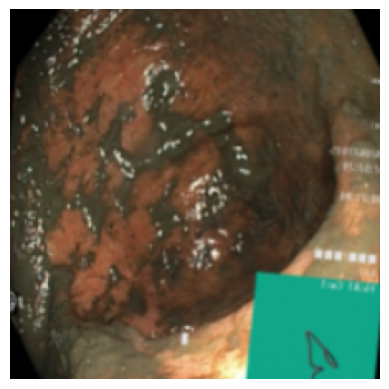

In [167]:
display_tensor_image(splitted_dataset["train"][0]["pixel_values"])

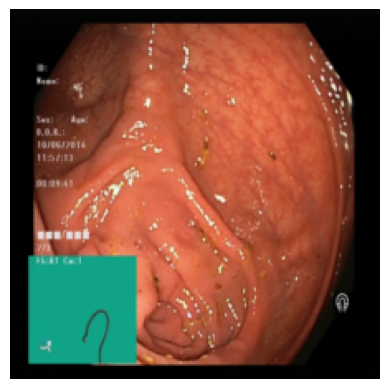

In [168]:
display_tensor_image(splitted_dataset["valid"][0]["pixel_values"])

In [169]:
model = TFAutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
#     ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [170]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="np")

In [171]:
splitted_dataset["train"][0]

{'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[-0.9898033 , -0.99080235, -0.98809683, ..., -0.9970372 ,
          -0.99860036, -0.9981286 ],
         [-0.9915876 , -0.99174017, -0.9905334 , ..., -0.9940155 ,
          -0.99774534, -0.99887854],
         [-0.99040544, -0.9908231 , -0.9896632 , ..., -0.993237  ,
          -0.9948098 , -0.9959508 ],
         ...,
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ]],
 
        [[-0.9898033 , -0.99080235, -0.98809683, ..., -0.9970372 ,
          -0.99860036, -0.9981286 ],
         [-0.9915876 , -0.99174017, -0.9905334 , ..., -0.9940155 ,
          -0.99774534, -0.99887854],
         [-0.99040544, -0.9908231 , -0.9896632 , ..., -0.993237  ,
          -0

In [172]:
splitted_dataset["train"][0]

{'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[-0.99998564, -0.99993837, -0.99989116, ..., -0.9901821 ,
          -0.98442674, -0.98463124],
         [-0.9986744 , -0.9981586 , -0.99764276, ..., -0.9861678 ,
          -0.9866836 , -0.9871994 ],
         [-0.9921857 , -0.9923191 , -0.99245244, ..., -0.99215686,
          -0.99215686, -0.99215686],
         ...,
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ]],
 
        [[-0.99998564, -0.99993837, -0.99989116, ..., -0.9901821 ,
          -0.98442376, -0.984471  ],
         [-0.9986744 , -0.9981586 , -0.99764276, ..., -0.9861678 ,
          -0.9866836 , -0.9871994 ],
         [-0.9921857 , -0.9923191 , -0.99245244, ..., -0.99215686,
          -0

In [173]:
batch_size = 16
num_epochs = 10
num_train_steps = len(splitted_dataset["train"]) * num_epochs
learning_rate = 2e-4
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [176]:
data_collator = DefaultDataCollator(return_tensors="np")

train_dataset = splitted_dataset["train"].to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
valid_dataset = splitted_dataset["valid"].to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

In [177]:
# from tensorflow.keras.losses import SparseCategoricalCrossentropy

# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss)

In [178]:
train_dataset

<PrefetchDataset element_spec={'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None)}>

In [179]:
batch = next(iter(train_dataset))
batch

{'labels': <tf.Tensor: shape=(16,), dtype=int64, numpy=array([5, 3, 1, 3, 1, 1, 2, 1, 6, 2, 0, 7, 4, 2, 5, 2], dtype=int64)>,
 'pixel_values': <tf.Tensor: shape=(16, 3, 224, 224), dtype=float32, numpy=
 array([[[[-0.97875994, -0.9731497 , -0.9718195 , ..., -0.8115642 ,
           -0.5948916 , -0.44251168],
          [-0.7543458 , -0.71210504, -0.7312536 , ..., -0.7623793 ,
           -0.55845004, -0.47169274],
          [-0.48444602, -0.42377552, -0.5425358 , ..., -0.80762935,
           -0.7180626 , -0.71048903],
          ...,
          [-0.62647015, -0.68021685, -0.80723196, ..., -1.        ,
           -1.        , -1.        ],
          [-0.5807664 , -0.6478411 , -0.7378885 , ..., -1.        ,
           -1.        , -1.        ],
          [-0.5244789 , -0.60858476, -0.75473607, ..., -1.        ,
           -1.        , -1.        ]],
 
         [[-0.97875994, -0.9731497 , -0.9718195 , ..., -0.8115642 ,
           -0.5948916 , -0.44251168],
          [-0.7543458 , -0.71210504, -

In [180]:
import numpy as np
from transformers.keras_callbacks import KerasMetricCallback

# the compute_metrics function takes a Tuple as input:
# first element is the logits of the model as Numpy arrays,
# second element is the ground-truth labels as Numpy arrays.
def compute_metrics(eval_predictions):
    predictions = np.argmax(eval_predictions[0], axis=1)
    metric_val = metric.compute(predictions=predictions, references=eval_predictions[1])
    return {"val_" + k: v for k, v in metric_val.items()}

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=test_dataset, batch_size=batch_size, label_cols=['labels']
)

NameError: name 'test_dataset' is not defined

In [109]:
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="./Graph3", histogram_freq=0, write_graph=True, write_images=True)
# early_stopping_callback = callbacks.EarlyStopping(monitor="val_accuracy",patience=3)
# model_name = model_checkpoint.split("/")[-1]
# push_to_hub_model_id = f"{model_name}-finetuned-eurosat"

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./ic_from_scratch_model_save",
#     hub_model_id=push_to_hub_model_id,
#     tokenizer=feature_extractor
# )

In [110]:
callbacks = [metric_callback, tensorboard_callback] 

In [111]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [112]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    callbacks=callbacks,
    epochs=num_epochs,
    batch_size=batch_size,
)

Epoch 1/10
1435/1435 [==============================] - 764s 525ms/step - loss: 0.3654 - val_loss: 0.1939 - val_accuracy: 0.9405
Epoch 2/10
1435/1435 [==============================] - 749s 522ms/step - loss: 0.1950 - val_loss: 0.0901 - val_accuracy: 0.9741
Epoch 3/10
1435/1435 [==============================] - 747s 521ms/step - loss: 0.1427 - val_loss: 0.0797 - val_accuracy: 0.9731
Epoch 4/10
1435/1435 [==============================] - 784s 546ms/step - loss: 0.1260 - val_loss: 0.1432 - val_accuracy: 0.9556
Epoch 5/10
1435/1435 [==============================] - 743s 518ms/step - loss: 0.1176 - val_loss: 0.1149 - val_accuracy: 0.9637
Epoch 6/10
1435/1435 [==============================] - 767s 534ms/step - loss: 0.1016 - val_loss: 0.0834 - val_accuracy: 0.9738
Epoch 7/10
1435/1435 [==============================] - 726s 506ms/step - loss: 0.0958 - val_loss: 0.0909 - val_accuracy: 0.9704
Epoch 8/10
1435/1435 [==============================] - 729s 508ms/step - loss: 0.0973 - val_loss

In [70]:
model.save_pretrained("./saved_model_fined_tuned3")

In [71]:
!tensorboard --logdir=./Graph3

^C


In [72]:
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6006: logdir ./Graph3 (started 12:01:43 ago; pid 37880)


In [73]:
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir ./Graph3 (started 12:01:43 ago; port 6006, pid 37880).


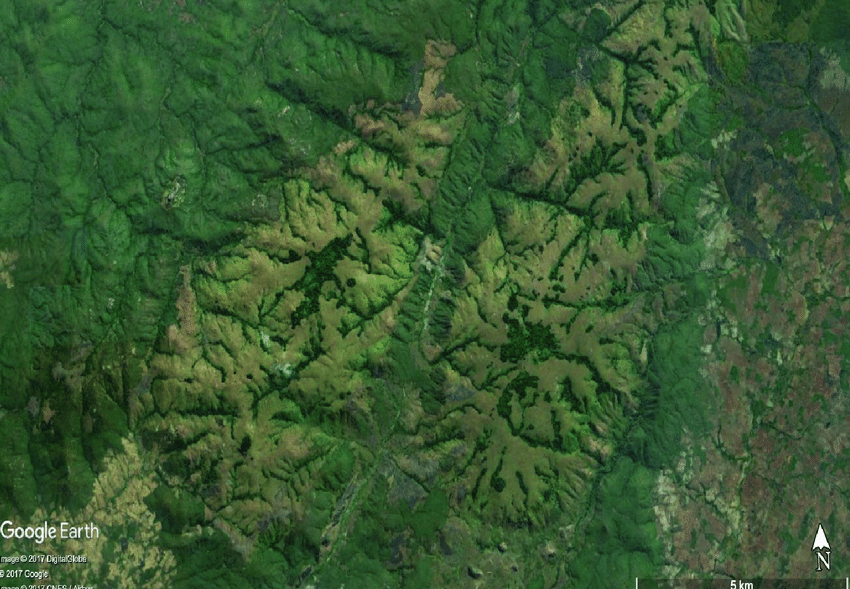

In [74]:
from PIL import Image
import requests

url = 'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurostat/resolve/main/forest.png'
image = Image.open(requests.get(url, stream=True).raw)
image

In [75]:
from transformers import AutoModelForSequenceClassification, AutoFeatureExtractor

repo_name = "./saved_model_fined_tuned3"

model = TFAutoModelForImageClassification.from_pretrained(repo_name)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at ./saved_model_fined_tuned3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [76]:
# prepare image for the model
encoding = processor(image.convert("RGB"), return_tensors="tf")
print(encoding.pixel_values.shape)

(1, 3, 224, 224)


In [77]:
outputs = model(encoding)
logits = outputs.logits

In [78]:
logits

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-1.3353332 ,  4.176551  , -0.60644007, -1.964542  , -0.64740103,
        -0.3074219 , -0.89783925,  4.629105  , -2.3363812 , -1.3702449 ]],
      dtype=float32)>

In [79]:
predicted_class_idx = tf.math.argmax(logits, -1).numpy()[0]
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Residential
